In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval

    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel('X', fontsize=20)
        ax.set_ylabel('Y', fontsize=20)

        elems = []
        
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax) #デバッグ時はアニメーションなし
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()

    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10)) 
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)

In [3]:
class IdealRobot:
  def __init__(self, pose, agent=None, color='black'):
    self.pose = pose
    self.r = 0.2
    self.color = color
    self.agent = agent
    self.poses = [pose]
  
  def draw(self, ax, elems):
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x, xn], [y, yn], color=self.color)
    c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
    elems.append(ax.add_patch(c))

    self.poses.append(self.pose) #軌跡の描画用
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color='black')

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
      t0 = pose[2]
      if math.fabs(omega) < 1e-10:
          return pose + np.array([nu*math.cos(t0), nu*math.sin(t0), omega])*time
      else:
          return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                                  nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                  omega*time])
      
  def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
    
    def decision(self, observation=None):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


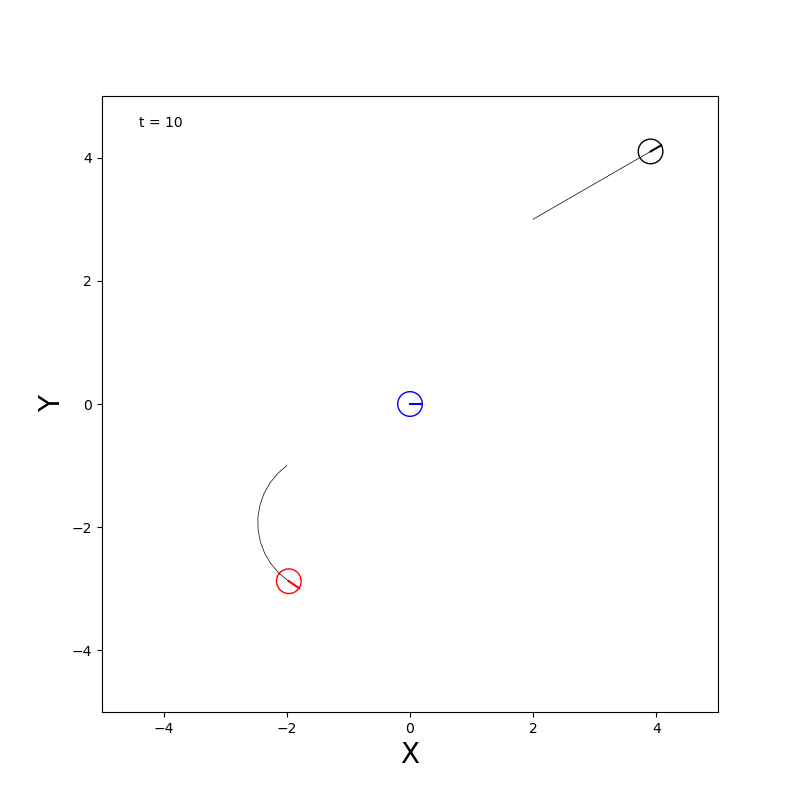

In [5]:
world = World(10, 1)
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進     
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )  
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")  
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

In [6]:
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0, 0, 0]).T)

array([0.1, 0. , 0. ])

In [7]:
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

In [8]:
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 18.0, np.array([0, 0, 0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])